<a href="https://colab.research.google.com/github/geo-vitoriano/sales_predict/blob/main/sales_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## O Dataset e o Projeto
<hr>



<p style='font-size: 18px; line-height: 2; margin: 10px 50px; text-align: justify;'>O objetivo deste projeto será estimar um modelo de <b>Machine Learning</b> utilizando a técnica de <b>Regressão Linear</b>. No final do projeto teremos um modelo de previsão para a venda de cerveja nos próximos 30 dias, dentro de uma série temporal.</p>

<p style='font-size: 18px; line-height: 2; margin: 10px 50px; text-align: justify;'>Os dados (amostra) foram coletados numa base de dados transacional, do ramo de vendas de certificado digital,entre os períodos de 01/2020 e 10/2023.</p>

### Dados:
<ul style='font-size: 18px; line-height: 2; text-align: justify;'>
    <li><b>ano</b> - Ano</li>
    <li><b>dia_do_mes</b> - Dia do Mês</li>
    <li><b>dia_semana</b> - Dia da Semana </li>
    <li><b>dia_do_ano</b> - Dia do ano</li>
    <li><b>qtd</b> - Quantidade vendida (un)</li>
    <li><b>atacado</b> - Venda para atacado (1 = Sim; 0 = Não)</li>
    <li><b>aalor</b> - Valor das vendas (R$)</li>


</ul>

## <font color='orange' style='font-size: 30px;'>Importação das bibliotecas</font>
<hr style='border: 2px solid red;'>

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
import random
import warnings
import seaborn as sns
warnings.filterwarnings('ignore') # ou warnings.filterwarnings(action='once')
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn import metrics
import os

## <font color='orange' style='font-size: 20px;'>Extração dos dados</font>
<hr style='border: 2px solid red;'>

In [5]:
# Criação no diretório de pastas para armazenar a base de dados
#os.mkdir('/content/dados')

In [6]:
# pasta = '/content/dados'

# # Lista para armazenar os DataFrames de cada arquivo
# dataframes = []

# # Iteracao sobre os arquivos na pasta
# for arquivo in os.listdir(pasta):
#     if arquivo.endswith('.csv'):
#         caminho_arquivo = os.path.join(pasta, arquivo)

#         # Lê o arquivo CSV usando pandas
#         df = pd.read_csv(caminho_arquivo, sep=";", encoding='latin-1')

#         # Adiciona o DataFrame à lista
#         dataframes.append(df)

# # Concatena todos os DataFrames em um único DataFrame, se desejar
# dados = pd.concat(dataframes, ignore_index=True)


lista_arquivos = list()
lista_arquivos.append('https://raw.githubusercontent.com/geo-vitoriano/sales_predict/main/dados/vendas_2020.zip')
lista_arquivos.append('https://raw.githubusercontent.com/geo-vitoriano/sales_predict/main/dados/vendas_2021.zip')
lista_arquivos.append('https://raw.githubusercontent.com/geo-vitoriano/sales_predict/main/dados/vendas_2022.zip')
lista_arquivos.append('https://raw.githubusercontent.com/geo-vitoriano/sales_predict/main/dados/vendas_2023.zip')

dataframes = []

for arquivo in lista_arquivos :
  df = pd.read_csv(arquivo, sep=';', compression='zip')
  dataframes.append(df)

dados = pd.concat(dataframes, ignore_index=True)

In [7]:
dados.sort_values(by=['Emissão Certificado'], inplace=True)

In [8]:
dados.head(4)

,1o. Agrupamento,2o. Agrupamento,3o. Agrupamento,Situação do Pedido,ID Pedido E-commerce,Nº ticket,Emissão Pedido,Emissão Certificado,Parceiro,Agente de Registro,Recurso,Troca de Mídia,Tipo de Atendimento,Qtd,Valor,Média,Desconto,Origem,Atacado,Cupom Desconto
494494,SP,SP - SANTOS,CPC Pontos Atacadistas,Emitido,CPC_91501,593122011865000C,NaN,01/01/2022,BERTCELL EXCLUSIVE TELEFONIA LTDA,CEZAR HENRIQUE DA SILVA BUENO FERREIRA,E-CNPJ A1,NaN,Não informado,1,"75,5",0,0,Sistema Legado,Sim,NaN
789653,CE,CE - AR DAVOS,CPC Pontos AR,Emitido,MDR_38838743,082b4aee9f9a,NaN,01/01/2023,CE - AR DAVOS,ALINE MARIA TIMOTEO DE AZEVEDO,E-CPF A3 DE 3 ANOS EM TOKEN,NaN,Não informado,1,"152,53",0,0,Sistema Legado,Sim,NaN
96413,PI,PI - TERESINA EURO,CPC Pontos Indiretos,Emitido,MDR_220547,731E210201475537,NaN,01/02/2020,MARCILIA FELLIPPE VAZ DE ARAUJO,JESSICA KELLY ESCORCIO DE ARAUJO,E-CPF A3 DE 3 ANOS EM TOKEN,NaN,Não informado,1,"340,8",0,85.2,Sistema Legado,Não,P.PI-TERESINAEURO20
96410,PI,PI - TERESINA EURO,CPC Pontos Indiretos,Emitido,MDR_220819,731E21020165D9CC,NaN,01/02/2020,JOSE DE MOURA SARAIVA NETO,JESSICA KELLY ESCORCIO DE ARAUJO,E-CPF A1,NaN,Não informado,1,"127,2",0,31.8,Sistema Legado,Não,P.PI-TERESINAEURO20


## <font color='orange' style='font-size: 20px;'>Tratamento dos dados</font>
<hr style='border: 2px solid red;'>

In [9]:
# Reduzindo o dataset para os campos que interessam na modelagem.
dados = dados[['Emissão Certificado', 'Desconto', 'Valor', 'Qtd', 'Atacado']]
# Renomeando os campos
dados = dados.rename(columns={"Emissão Certificado": "data",
                              "Valor": "valor",
                              "Qtd": "qtd",
                              "Atacado" : "atacado",
                              "Desconto": "desconto"})
# Alterando os tipos de dados
dados['data'] = pd.to_datetime(dados['data'], errors='coerce')
dados['valor'] = dados['valor'].str.replace(',','.').astype(float)
dados['desconto'] = dados['desconto'].astype(str)
dados['desconto'] = dados['desconto'].str.replace(',','.').astype(float)
# Alterando a informação do campo para binária.
for index, row in dados.iterrows() :
  if row['atacado'] == 'Sim' :
     dados.at[index, 'atacado'] = 1
  else :
    dados.at[index, 'atacado'] = 0
# Gerando a totalização por dia e atacado.
grupo = dados.groupby(['data', 'atacado'])['valor', 'desconto', 'qtd'].sum()

l_data = list()
l_valor = list()
l_qtd = list()
l_desconto = list()
l_atacado = list()

for v in grupo.values :
  l_valor.append(v[0])
  l_desconto.append(v[1])
  l_qtd.append(v[2])

for v in grupo.index :
  l_data.append(v[0])
  l_atacado.append(v[1])

dados = pd.DataFrame({'data' :l_data,
                      'atacado' : l_atacado,
                      'valor' : l_valor,
                      'qtd' : l_qtd})

dados.sort_values(by=['data'], inplace=True)


In [10]:
# Dataset reduzido
dados.head(4)

,data,atacado,valor,qtd
0,2020-01-02,0,74363.66,538.0
1,2020-01-02,1,1221.63,16.0
2,2020-01-03,0,75929.53,512.0
3,2020-01-03,1,1909.94,26.0


## <font color='orange' style='font-size: 20px;'>Criação de novos campos para a modelagem</font>
<hr style='border: 2px solid red;'>

In [11]:
dados = dados.reset_index(drop=True)

dados['dia_do_ano'] = dados['data'].dt.dayofyear
dados['mes'] = dados['data'].dt.month
dados['dia_semana'] = dados['data'].dt.dayofweek
dados['dia_do_mes'] = dados['data'].dt.day
dados['mes_ano'] = dados['data'].dt.month.map(str) + '/' + dados['data'].dt.year.map(str)
dados['ano'] = dados['data'].dt.year


# Retirando os outliars
filtro = dados['valor'] > 50.00
dados = dados[filtro]

dados.head(5)


,data,atacado,valor,qtd,dia_do_ano,mes,dia_semana,dia_do_mes,mes_ano,ano
0,2020-01-02,0,74363.66,538.0,2,1,3,2,1/2020,2020
1,2020-01-02,1,1221.63,16.0,2,1,3,2,1/2020,2020
2,2020-01-03,0,75929.53,512.0,3,1,4,3,1/2020,2020
3,2020-01-03,1,1909.94,26.0,3,1,4,3,1/2020,2020
4,2020-01-04,0,48468.36,353.0,4,1,5,4,1/2020,2020


## <font color='orange' style='font-size: 20px;'>Análise dos dados</font>
<hr style='border: 2px solid red;'>

In [12]:
dados.shape
print(f'Quantidade de colunas : {dados.shape[1]}')
print(f'Quantidade de linhas : {dados.shape[0]}')

Quantidade de colunas : 10
Quantidade de linhas : 2630


In [13]:
# Quantidade de dados nulos
total_nulos = dados.isna().sum().sum()
print(f'Quantidade de dados nulos : {total_nulos}')

Quantidade de dados nulos : 0


In [14]:
dados.shape[0]

2630

In [15]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2630 entries, 0 to 2654
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   data        2630 non-null   datetime64[ns]
 1   atacado     2630 non-null   int64         
 2   valor       2630 non-null   float64       
 3   qtd         2630 non-null   float64       
 4   dia_do_ano  2630 non-null   int64         
 5   mes         2630 non-null   int64         
 6   dia_semana  2630 non-null   int64         
 7   dia_do_mes  2630 non-null   int64         
 8   mes_ano     2630 non-null   object        
 9   ano         2630 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(1)
memory usage: 290.6+ KB


## <font color='orange' style='font-size: 20px;'>Estatística descritiva</font>
<hr style='border: 2px solid red;'>

In [16]:
#dados = df_serie_temporal
dados.describe().round(2)

,atacado,valor,qtd,dia_do_ano,mes,dia_semana,dia_do_mes,ano
count,2630.00,2630.00,2630.00,2630.00,2630.00,2630.00,2630.00,2630.00
mean,0.49,37736.95,403.92,186.42,6.63,2.87,15.77,2021.54
std,0.50,35061.50,358.39,104.37,3.41,1.96,8.73,1.12
min,0.00,52.02,1.00,1.00,1.00,0.00,1.00,2020.00
25%,0.00,3102.77,36.00,97.00,4.00,1.00,8.00,2021.00
50%,0.00,24441.29,336.00,188.50,7.00,3.00,16.00,2022.00
75%,1.00,75497.93,647.00,276.00,10.00,5.00,23.00,2023.00
max,1.00,114850.86,1519.00,366.00,12.00,6.00,31.00,2023.00


## <font color='orange' style='font-size: 20px;'>Matriz de correlação

In [17]:
df_corr = dados.corr().round(2)['valor']
df_corr

atacado      -0.65
valor         1.00
qtd           0.91
dia_do_ano   -0.02
mes          -0.02
dia_semana   -0.18
dia_do_mes    0.00
ano          -0.00
Name: valor, dtype: float64

## <font color='orange' style='font-size: 30px;'>Comportamento da Variável Dependente (Y)</font>
<hr style='border: 2px solid red;'>

## <font color='orange' style='font-size: 30px;'>Análise Gráfica (Y)</font>
<hr style='border: 2px solid red;'>

## <font color='orange' style='font-size: 30px;'>Distribuição de frequências da variável *dependente* (y)</font>
<hr style='border: 2px solid red;'>



<Axes: title={'center': 'Distribuição de Frequências'}, xlabel='valor', ylabel='Total R$'>

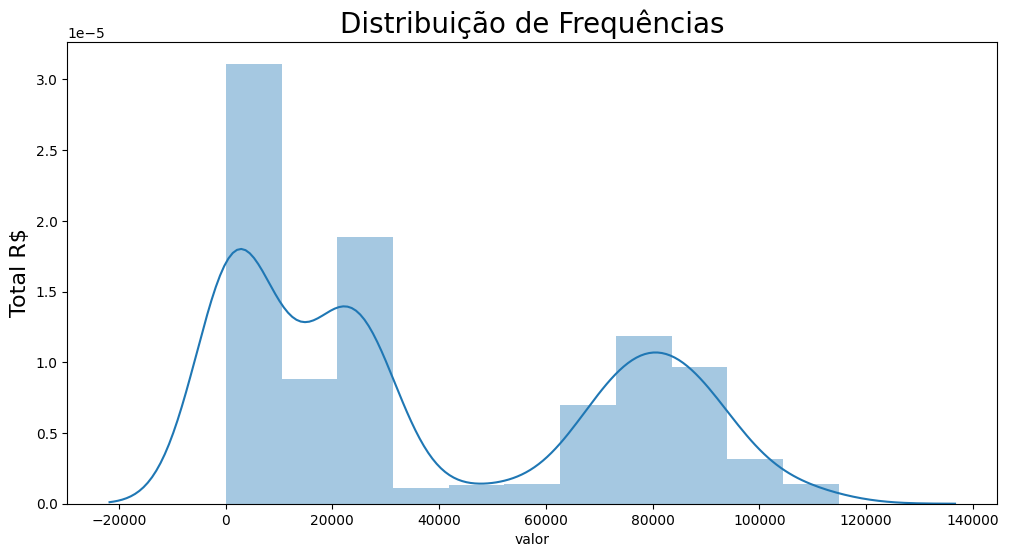

In [18]:
ax = sns.distplot(dados['valor'])
ax.figure.set_size_inches(12, 6)
ax.set_title('Distribuição de Frequências', fontsize=20)
ax.set_ylabel('Total R$', fontsize=16)
ax

## <font color='orange' style='font-size: 30px;'>Análise de série temporal</font>
<hr style='border: 2px solid red;'>

In [19]:
grupo_ano = dados.groupby(['data', 'mes', 'ano'])['valor'].sum()

l_data = list()
l_ano = list()
l_mes_ano = list()
l_valor = list()
l_mes = list()

for v in grupo_ano.index :
  l_data.append(v[0])
  l_mes.append(v[1])
  l_ano.append(v[2])


df_valor_mesal = pd.DataFrame({'ano' : l_ano,
                             'mes' : l_mes,
                             'data' : l_data,
                             'valor' : grupo_ano.values})

df_valor_mesal.sort_values(by=['ano','mes'], inplace=True)

df_valor_mesal.head(4)

,ano,mes,data,valor
0,2020,1,2020-01-02,75585.29
1,2020,1,2020-01-03,77839.47
2,2020,1,2020-01-04,49970.99
3,2020,1,2020-01-05,424.00


## <font color='orange' style='font-size: 30px;'>Anual</font>
<hr style='border: 2px solid red;'>

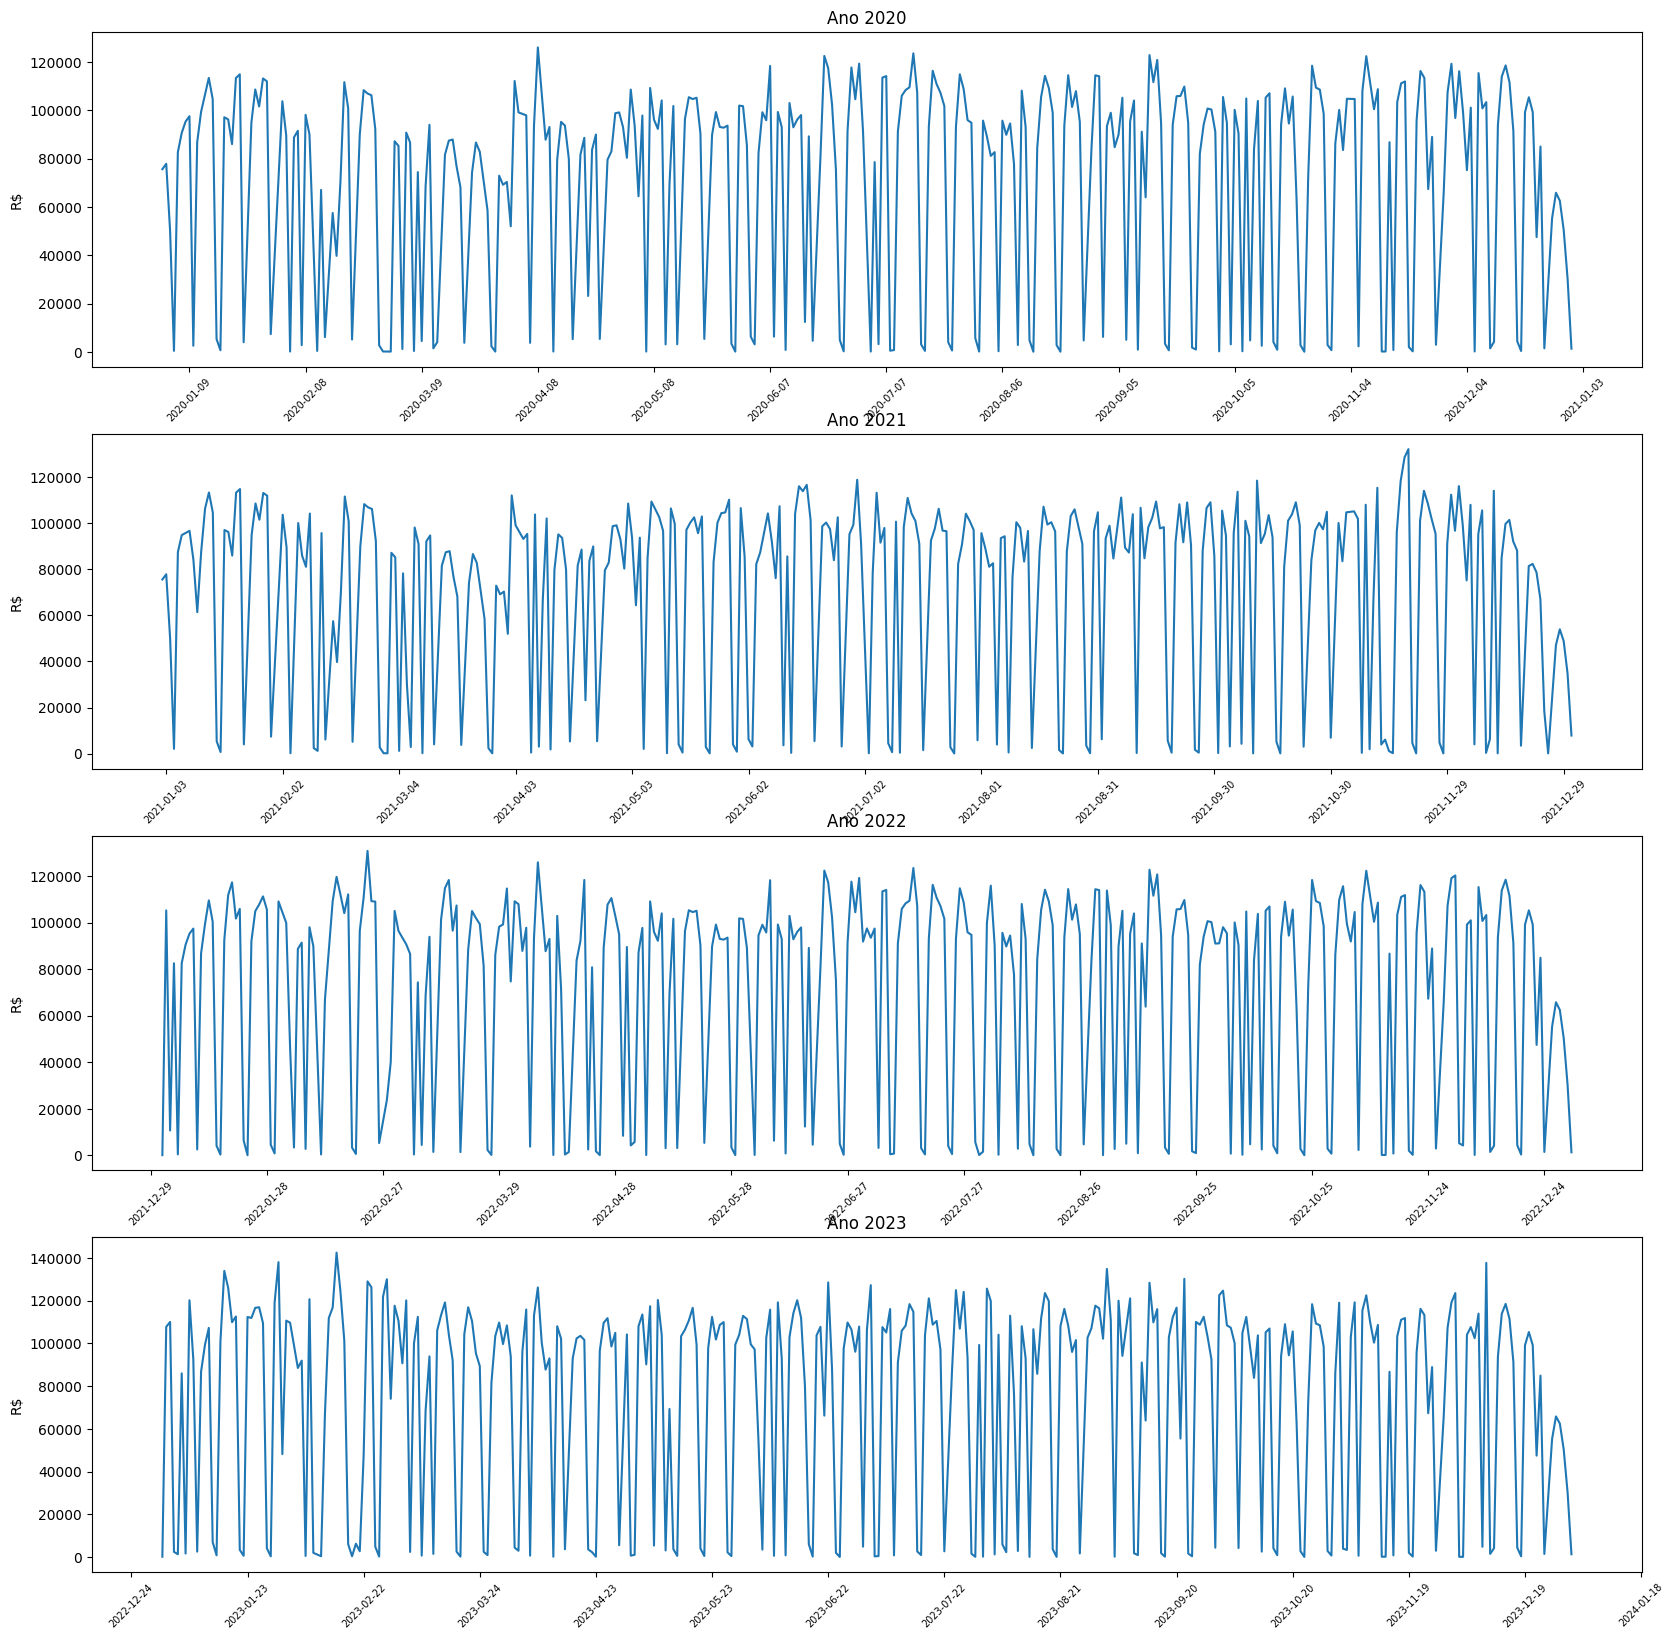

In [20]:
anos = dados['data'].dt.year.unique()

# Criando a figura
fig, axs = plt.subplots(4, 1, figsize=(20,20))
ind = 0

for subplot, ano in enumerate(anos):

  datas = df_valor_mesal[df_valor_mesal['ano'] == ano]['data']
  valores = df_valor_mesal[df_valor_mesal['ano'] == ano]['valor']

  # Subplot 1: Gráfico de linhas
  axs[ind].plot( datas, valores)
  axs[ind].set_title('Ano ' + str(ano))
  axs[ind].set_xlabel('', rotation=70)
  axs[ind].set_ylabel('R$')
  axs[ind].xaxis.set_tick_params(rotation=45)
  #axs[ind].set_xticklabels(datas, fontsize=10)
  axs[ind].xaxis.set_tick_params(labelsize=7)
  axs[ind].xaxis.set_major_locator(plt.MultipleLocator(30))
  ind += 1


fig.show()



## <font color='orange' style='font-size: 30px;'>Mensal</font>
<hr style='border: 2px solid red;'>

In [21]:
grupo_mes = dados.groupby(['mes_ano','ano','mes'])['valor'].sum()

l_ano = list()
l_mes_ano = list()
l_desconto = list()
l_valor = list()
l_mes = list()

for v in grupo_mes.index :
  l_mes_ano.append(v[0])
  l_ano.append(v[1])
  l_mes.append(v[2])



df_valor_anual = pd.DataFrame({'mes_ano' : l_mes_ano,
                               'ano' : l_ano,
                               'mes' : l_mes,
                               'valor' : grupo_mes.values})

df_valor_anual.sort_values(by=['ano','mes'], inplace=True)

df_valor_anual.head(4)


,mes_ano,ano,mes,valor
0,1/2020,2020,1,2137636.44
16,2/2020,2020,2,1529533.72
20,3/2020,2020,3,1591319.77
24,4/2020,2020,4,1944510.12


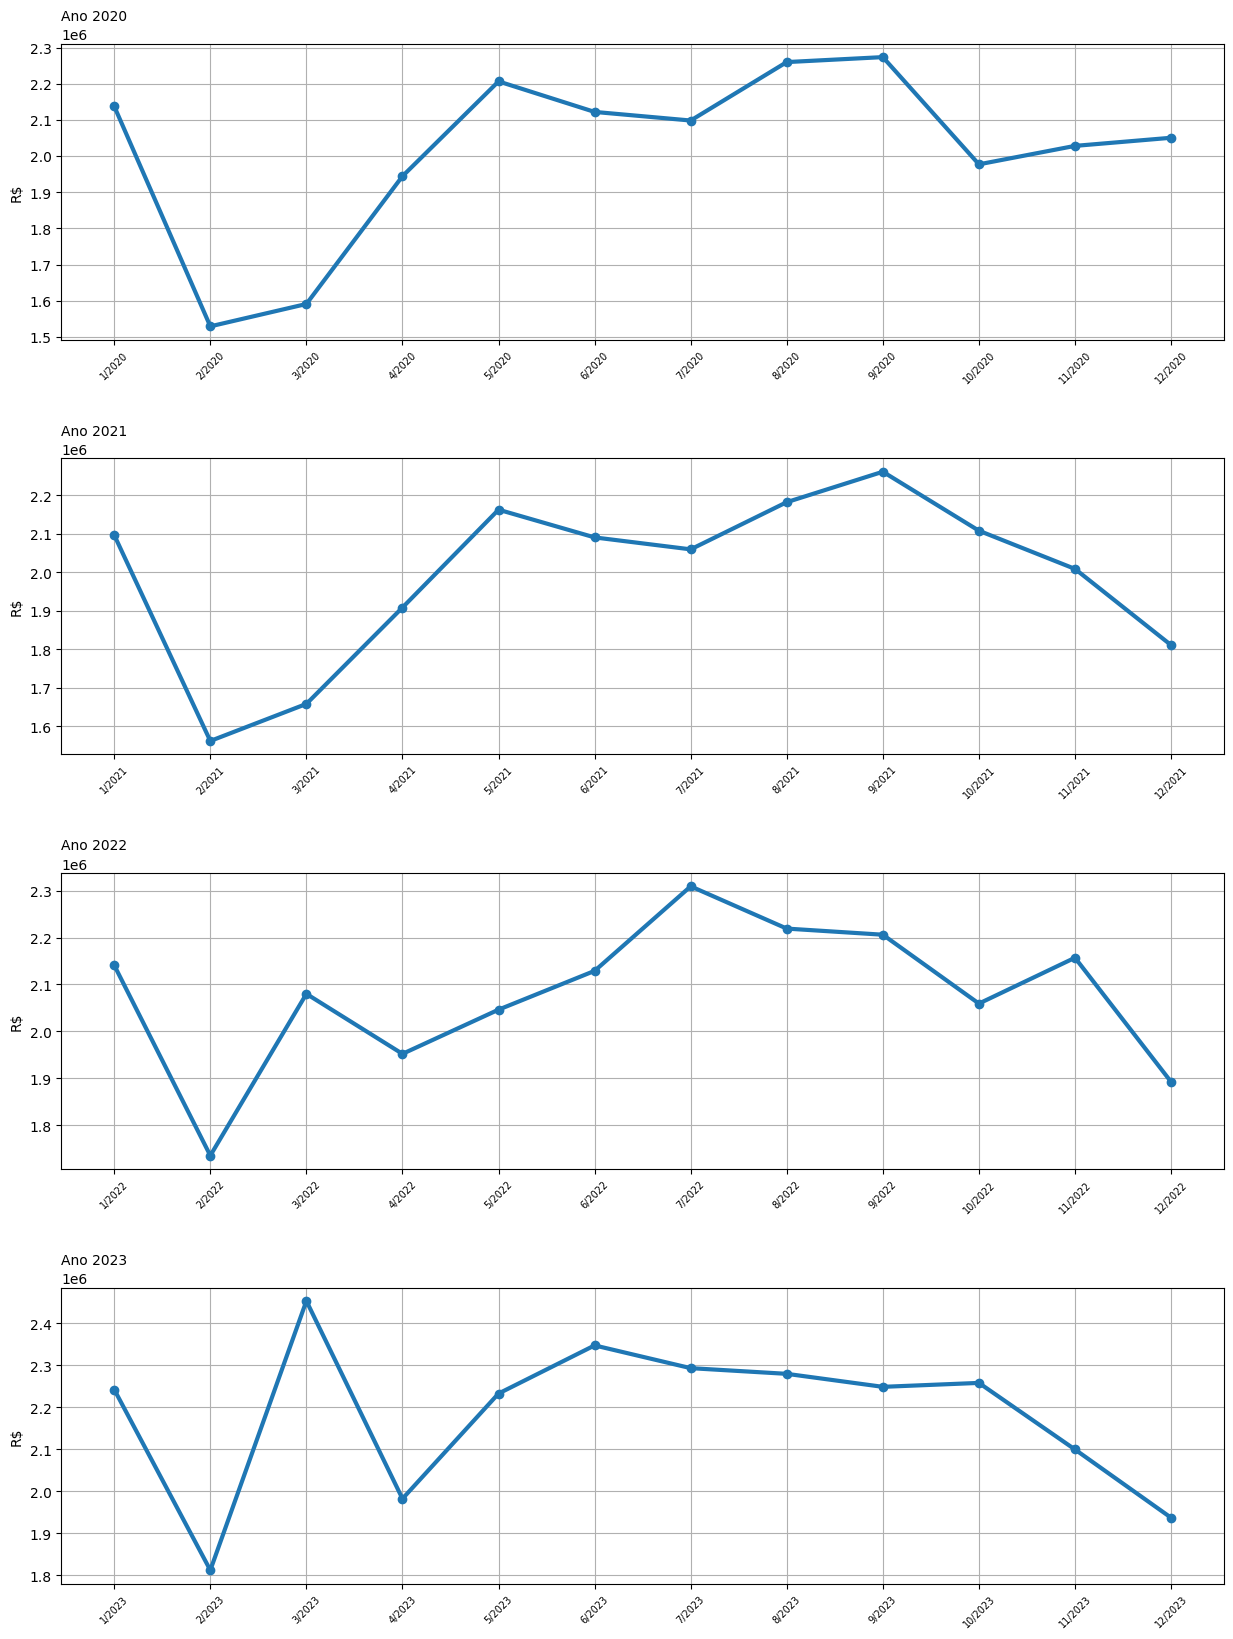

In [22]:
# Criando a figura
fig, axs = plt.subplots(4, 1, figsize=(15,20))
ind = 0

for subplot, ano in enumerate(anos):

  datas = df_valor_anual[df_valor_anual['ano'] == ano]['mes_ano']
  valores = df_valor_anual[df_valor_anual['ano'] == ano]['valor']

  # Subplot 1: Gráfico de linhas
  axs[ind].plot( datas, valores, lw=3, marker='o')
  axs[ind].set_title('Ano ' + str(ano), fontsize=10, loc='left')
  axs[ind].set_xlabel('', rotation=70)
  axs[ind].set_ylabel('R$')
  axs[ind].xaxis.set_tick_params(rotation=45)

  #axs[ind].set_xticklabels(datas, fontsize=10)
  axs[ind].xaxis.set_tick_params(labelsize=7)
  axs[ind].xaxis.set_major_locator(plt.MultipleLocator(1))
  axs[ind].grid()
  ind += 1

# Ajustando o espaçamento
fig.subplots_adjust(hspace=0.4, wspace=0.3)

fig.show()



In [23]:
nome_mes = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
cores = ['#4682B4', '#8FBC8F', '#DC143C', '#FF7F50', '#DAA520', '#8B008B', '#FFA500', '#F0E68C', '#F08080', '#20B2AA', '#DC143C', '#FF7F50']

## <font color='orange' style='font-size: 30px;'>Por dia no mês</font>
<hr style='border: 2px solid red;'>

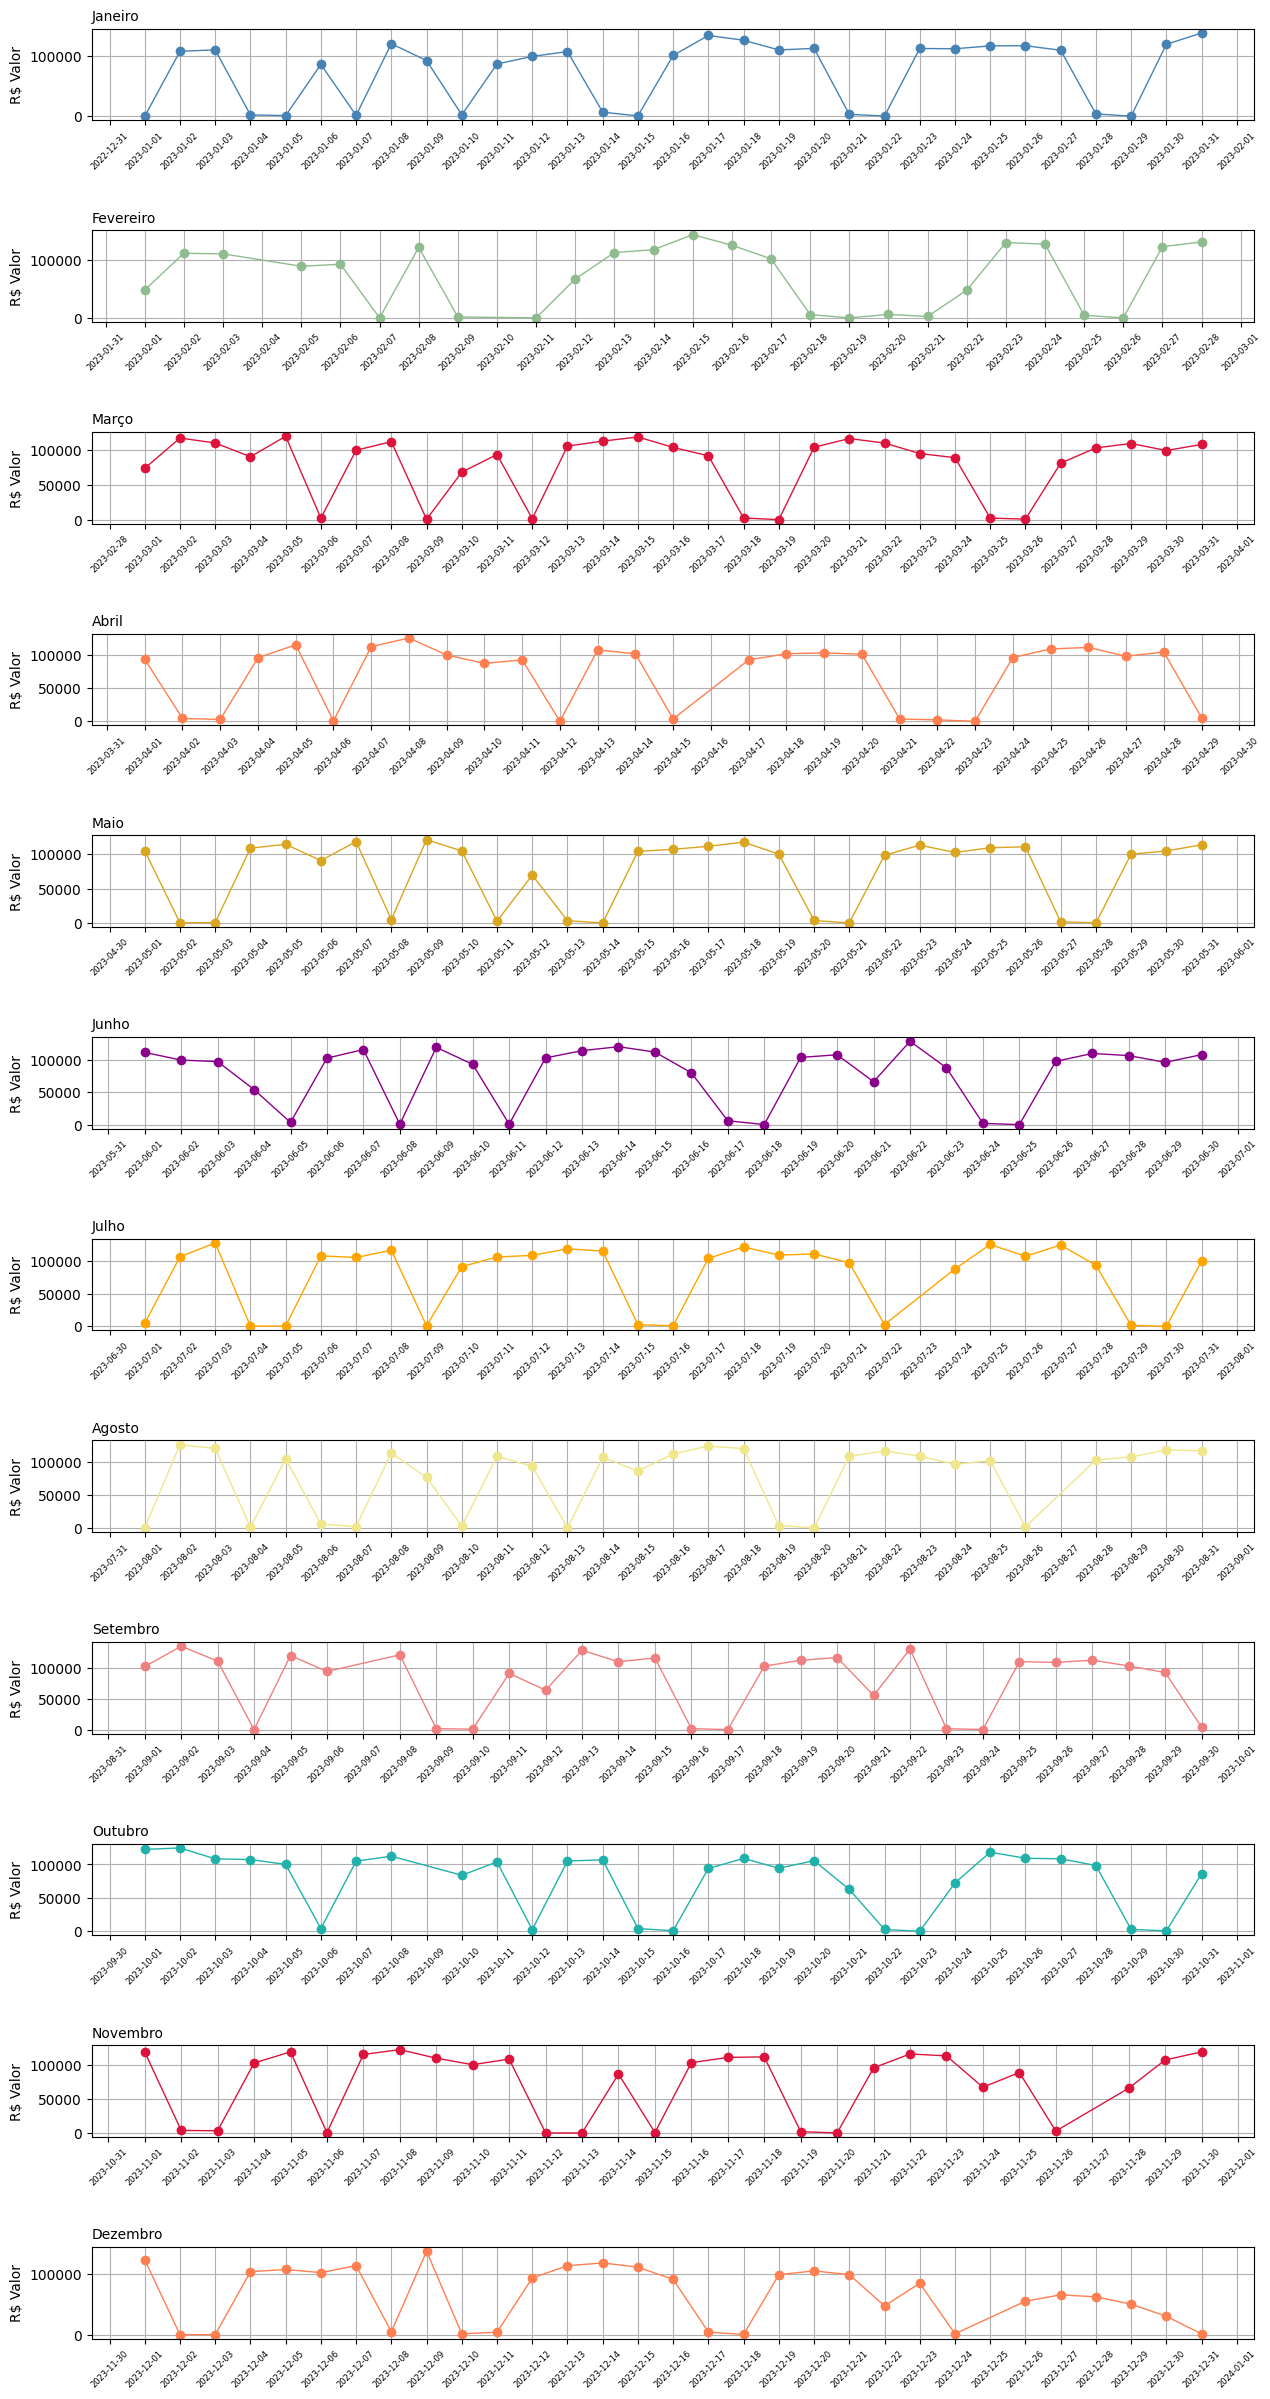

In [24]:
# df_serie_mes = df_serie_mes[(df_serie_mes['mes'] == 12) & (df_serie_mes['ano'] == 2021)]
# datas = df_serie_mes['data']
# consumo = df_serie_mes['valor']

# plt.figure(figsize=(14, 18))
# plt.subplot(len(anos), 1, subplot+1)
# plt.plot(datas, consumo, 'k-')
# plt.gca().twinx().plot(datas, consumo, '--y')

# Criando a figura

meses = df_valor_mesal['mes'].unique()
ano_analise = 2023

fig, axs = plt.subplots(12, 1, figsize=(15,30))
ind = 0

df_valor_mesal = df_valor_mesal[(df_valor_mesal['ano'] == ano_analise)]

for subplot, mes in enumerate(meses):

  datas = df_valor_mesal[df_valor_mesal['mes'] == mes]['data']
  valores = df_valor_mesal[df_valor_mesal['mes'] == mes]['valor']

  # Subplot 1: Gráfico de linhas
  axs[ind].plot( datas, valores, lw=1, marker='o', color=cores[mes-1])
  axs[ind].set_title('' + nome_mes[mes-1], fontsize=10, loc='left')
  axs[ind].set_xlabel('', rotation=70)
  axs[ind].set_ylabel('R$ Valor')
  axs[ind].xaxis.set_tick_params(rotation=45)
  #axs[ind].set_xticklabels(datas, fontsize=10)
  axs[ind].xaxis.set_tick_params(labelsize=6)
  axs[ind].grid()
  axs[ind].xaxis.set_major_locator(plt.MultipleLocator(1))
  ind += 1

fig.subplots_adjust(hspace=1.2, wspace=0.3)
fig.show()



## <font color='orange' style='font-size: 30px;'>Construção do Modelo</font>
<hr style='border: 2px solid red;'>

### <font color='orange' style='font-size: 30px;'>Funções</font>
<hr style='border: 2px solid red;'>

In [25]:
def create_dataset(df):

    X = []
    y = []

    for i in range(len(df) - windows_size):

        pos_target = i + windows_size
        #print('pos_target ', pos_target )
        target = df.iloc[pos_target]['valor']

        sample = []
        for f in features:
            if f == 'valor' :
                sample += list(df.iloc[i:pos_target][f].values)
            else:
                sample += [df.iloc[pos_target][f]]

        X.append(sample)
        y.append(target)

    return np.array(X), np.array(y)

def get_model():
    #return LinearRegression()
    # return DecisionTreeRegressor(min_samples_leaf=15, max_depth=10)
    #return AdaBoostRegressor()
    # return RandomForestRegressor(n_jobs=-1, n_estimators=50, random_state=123, max_depth=8, max_features=0.15, min_samples_leaf=15)
     return RandomForestRegressor(n_jobs=-1, n_estimators=200, max_depth=10, max_features=0.15, min_samples_leaf=15)

def predict(sample, model):

    predictions = []
    # Valores das variáves dependentes
    test_info = X_test[:, windows_size:]

    sample_to_predict = [sample.copy()]

    for i in range(test_size):

        sample_to_predict = sample_to_predict[0]
        #print('sample_to_predict = ', sample_to_predict )

        if i > 0:
            # Valores dos target
            sales = list(sample_to_predict[1:windows_size]) + [y]
            # Valores das variáveis dependentes
            others = list(test_info[i])

            sample_to_predict = sales + others

        sample_to_predict = np.array([sample_to_predict])
        y = model.predict(sample_to_predict)[0]

        predictions.append(y)

    return predictions

## <font color='orange' style='font-size: 30px;'>Parâmetros do modelo</font>
<hr style='border: 2px solid red;'>

In [26]:
windows_size = 365 # ref. day
val_size = 0 # ref. day
test_size = 30 # ref. day
train_size = len(dados) - val_size - test_size

features = [ 'valor',	'qtd', 'atacado', 'mes', 'dia_do_ano', 'dia_semana', 'dia_do_mes', 'ano']

print(f'windows_size = {windows_size}')
print(f'train_size = {train_size}')
print(f'val_size = {val_size}')
print(f'test_size = {test_size}')
print(f'features = {features}')


windows_size = 365
train_size = 2600
val_size = 0
test_size = 30
features = ['valor', 'qtd', 'atacado', 'mes', 'dia_do_ano', 'dia_semana', 'dia_do_mes', 'ano']


In [27]:
y_real = list(dados['valor'].iloc[-test_size:].values)


## <font color='orange' style='font-size: 30px;'>Criando o conjunto de treino e teste.</font>
<hr style='border: 2px solid red;'>

In [28]:
X, y = create_dataset(dados)

X.shape, y.shape

((2265, 372), (2265,))

## <font color='orange' style='font-size: 30px;'>Criando o conjunto de treino e teste.</font>
<hr style='border: 2px solid red;'>


In [29]:
X_test, y_test = X[-test_size:, :], y[-test_size:]
X_val, y_val = X[-test_size-val_size:-test_size, :], y[-test_size-val_size:-test_size]
X_train, y_train = X[-test_size-val_size-train_size:-test_size-val_size, :], y[-test_size-val_size-train_size:-test_size-val_size]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2235, 372), (2235,), (0, 372), (0,), (30, 372), (30,))


## <font color='orange' style='font-size: 30px;'>Geração a previsão</font>
<hr style='border: 2px solid red;'>

In [30]:
# Instância do modelo
model = get_model()
# Ajuste do modelo na correlação
model.fit(X_train, y_train)
# Previsão do modelo
#y_pred = model.predict(X_test)
y_pred = predict(X_test[0,:], model)


## <font color='orange' style='font-size: 30px;'>Resultado</font>
<hr style='border: 2px solid red;'>


## <font color='orange' style='font-size: 30px;'>Métricas de Erros</font>
<hr style='border: 2px solid red;'>

In [31]:
mae = mean_absolute_error(y_pred, y_test)
mse = mean_squared_error(y_pred, y_test)

print(f'MAE = {mae}')
print(f'MSE = {mse}')

MAE = 9376.007425018059
MSE = 148332776.6999733


## <font color='orange' style='font-size: 30px;'>Gráfico comparando valores reais com previstos</font>
<hr style='border: 2px solid red;'>

In [32]:
import plotly.express as px

In [33]:
dias = range(0, 30)

df_pred = pd.DataFrame(data = { 'dias' : dias, 'previsto': y_pred })
df_pred = df_pred.reset_index(drop = True)
df_pred

df_real = pd.DataFrame(data = { 'dias' : dias, 'real': y_real })
df_real = df_real.reset_index(drop = True)
df_real

df_final = pd.merge( df_pred, df_real, how='inner', on='dias' )


In [34]:
fig = px.line(df_final, x=df_final.index, y=df_final.columns[1:], markers = True)
fig.update_legends()
fig.update_layout(
    xaxis_title='Dias',
    yaxis_title='R$ Valor',
    legend=dict( orientation="v")
)

fig.show()